<a href="https://colab.research.google.com/github/AravindBethapudi/Image-Classification/blob/main/Deep_Learning_Image_Classification_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Classification With Transfer Learning in Keras

#  Importing Libraries

In [1]:
import tensorflow as tf
import tarfile
import urllib
import os
import numpy as np
import pets

from matplotlib import pyplot as plt
%matplotlib inline

data_dir = 'data/'
if not os.path.isdir(data_dir):
    os.mkdir(data_dir)

print('TensorFlow version:', tf.__version__)
print('Is using GPU?', tf.test.is_gpu_available())

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


TensorFlow version: 2.15.0
Is using GPU? False


# Cats vs Dogs Dataset

In [2]:
pets.download_and_extract('data', '.')

In [3]:
class_to_index = {'cat': 0, 'dog': 1}
index_to_class = {0: 'cat', 1: 'dog'}

train_annot, count_train = pets.cats_vs_dogs_annotations('data/annotations/trainval.txt')
test_annot, count_test = pets.cats_vs_dogs_annotations('data/annotations/test.txt')

print('Training examples count:', count_train)
print('Test examples count:', count_test)

Training examples count: 3680
Test examples count: 3669


# Get Random Batch

In [4]:
image_dir = 'data/images/'

def get_random_batch(annot, batch_size=4):
    all_keys = list(annot.keys())
    total_examples = len(all_keys)
    indices = np.random.choice(range(total_examples), batch_size)
    x = np.zeros((batch_size, 128, 128, 3))
    y = np.zeros((batch_size, 1))
    images = []

    for i, index in enumerate(indices):
        image = tf.keras.preprocessing.image.load_img(os.path.join(image_dir, all_keys[index]),
                                                     target_size=(128, 128))
        images.append(image)
        arr = tf.keras.preprocessing.image.img_to_array(image)
        arr = tf.keras.applications.mobilenet_v2.preprocess_input(arr)
        arr = np.expand_dims(arr, axis=0)
        x[i] = arr
        y[i] = class_to_index[annot[all_keys[index]]]

    return x, y, images

Displaying first 8 examples..


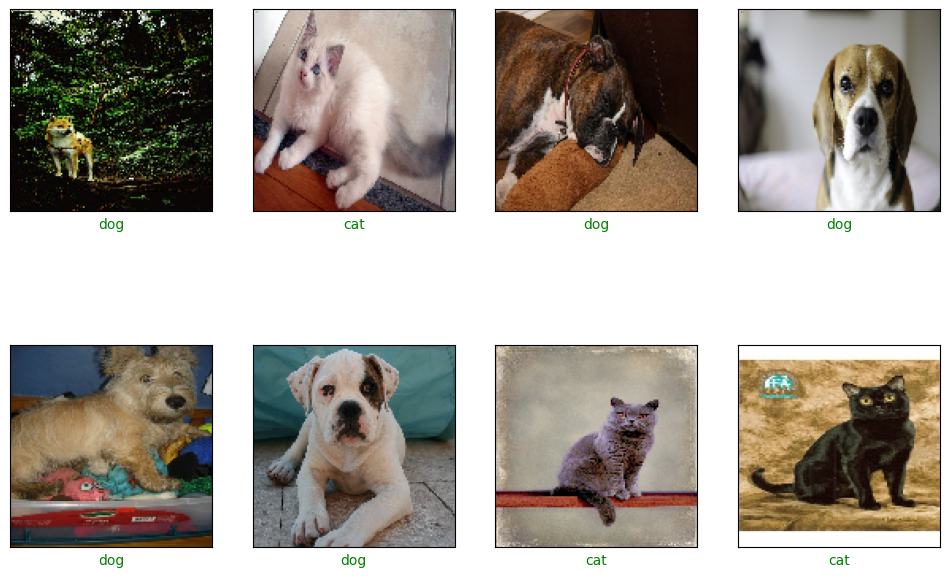

In [5]:
x, y, images = get_random_batch(train_annot, batch_size=8)
pets.display_examples(x, y, y, images, index_to_class).show()

# Create Model

In [6]:
mnet = tf.keras.applications.mobilenet_v2.MobileNetV2(include_top=False, input_shape=(128, 128, 3),
                                                     pooling='avg', weights='imagenet')
mnet.summary()

9406464/9406464 [==============================] - 0s 0us/step
Model: "mobilenetv2_1.00_128"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 64, 64, 32)           864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 64, 64, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReL

In [7]:
def create_model():
    model = tf.keras.models.Sequential([
        mnet,
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    model.layers[0].trainable = False
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
    return model

model = create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_128 (Func  (None, 1280)              2257984   
 tional)                                                         
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 1)                 1281      
                                                                 
Total params: 2259265 (8.62 MB)
Trainable params: 1281 (5.00 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


#  Model Training

In [8]:
def data_generator(batch_size, annot):
    while True:
        x, y, _ = get_random_batch(annot, batch_size)
        yield (x, y)

In [9]:
batch_size = 32
steps_per_epoch = int(len(list(train_annot.keys()))/batch_size)
validation_steps = int(len(list(test_annot.keys()))/batch_size)

print('Steps per epoch:', steps_per_epoch)
print('Validation steps:', validation_steps)

Steps per epoch: 115
Validation steps: 114


In [10]:
%%time

_ = model.fit_generator(
    data_generator(batch_size, train_annot),
    validation_data=data_generator(batch_size, test_annot),
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    epochs=1
)

<timed exec>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


115/115 [==============================] - 140s 1s/step - loss: 0.3204 - acc: 0.8668 - val_loss: 0.0957 - val_acc: 0.9756
CPU times: user 2min 20s, sys: 34 s, total: 2min 54s
Wall time: 2min 26s


# Predictions

1/1 [==============================] - 0s 90ms/step
Displaying first 8 examples..


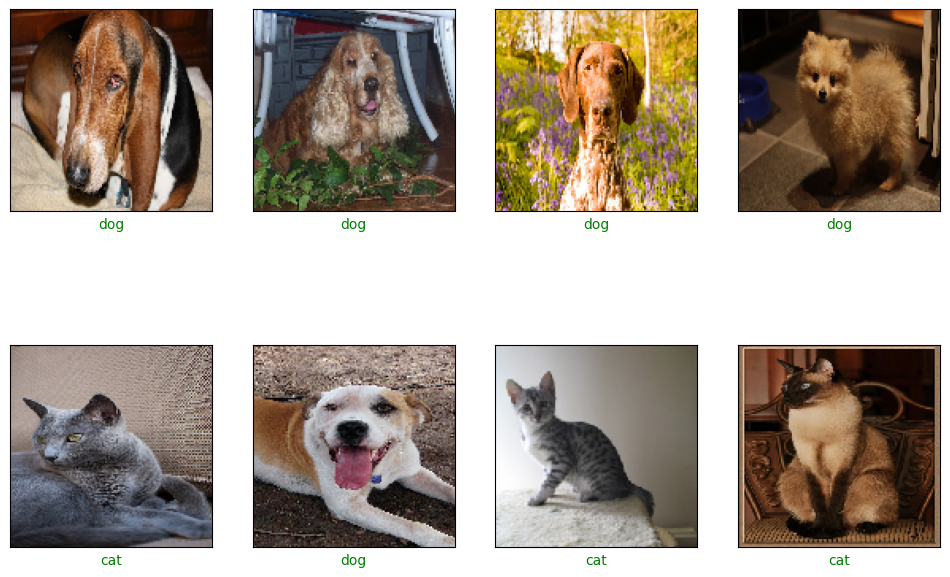

In [13]:
x, y, images = get_random_batch(test_annot, batch_size=8)
preds = model.predict(x)
pets.display_examples(x, y, preds, images, index_to_class).show()